# HR Diagram

In [166]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")
import pandas as pd

In [167]:
df_stars = pd.read_csv(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Data\stars.csv")

Quick data exploration

In [168]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_

In [169]:
import seaborn as sns
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Real Labels')

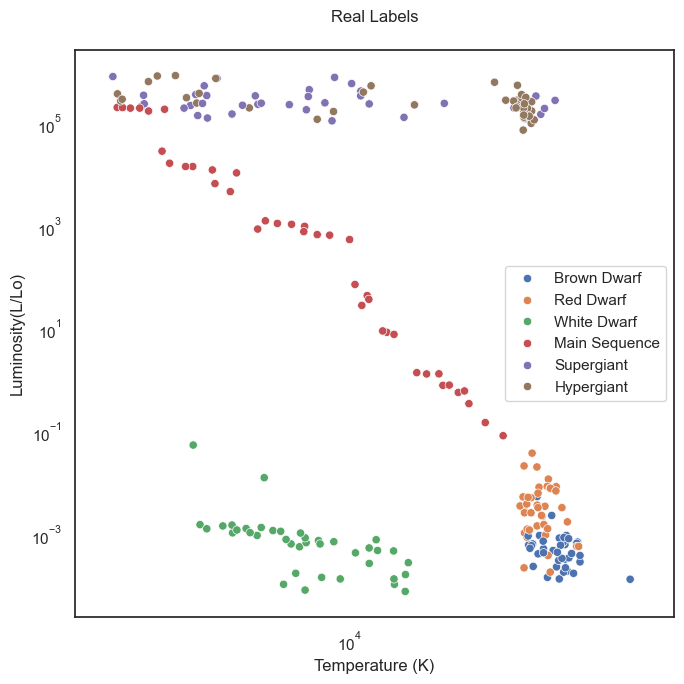

In [170]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.title('Real Labels')

## PCA

In [171]:
import numpy as np
X = np.vstack([df_stars['Absolute magnitude(Mv)'].to_numpy(), df_stars['Luminosity(L/Lo)'].to_numpy(), df_stars['Radius(R/Ro)'].to_numpy(), df_stars['Temperature (K)'].to_numpy()]).T

In [172]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA

In [173]:
X_scaled = StandardScaler().fit_transform(X)
y = df_stars['Star type'].to_numpy()

In [174]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

Text(0, 0.5, 'Explained variance ratio')

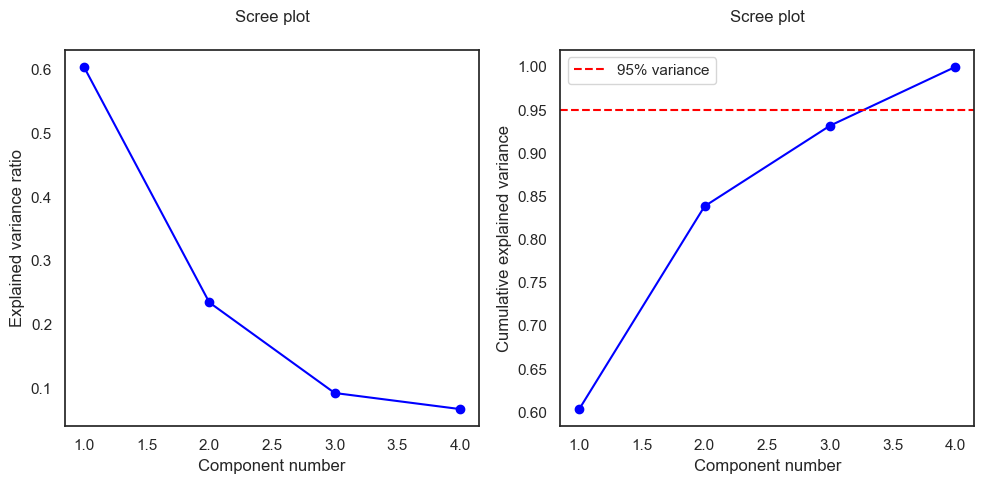

In [175]:
fig, axs = plt.subplots(1, 2)
axs[1].plot(range(1,pca.n_components+1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='blue')
axs[1].set_title('Scree plot')
axs[1].set_xlabel('Component number')
axs[1].axhline(0.95, 0, 1, linestyle='--', color='red', label='95% variance')
axs[1].set_ylabel('Cumulative explained variance')
axs[1].legend()

axs[0].plot(range(1,pca.n_components+1), pca.explained_variance_ratio_, marker='o', linestyle='-', color='blue')
axs[0].set_title('Scree plot')
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('Explained variance ratio')

In [176]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, shuffle=True, random_state=42)

In [178]:
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.fit_transform(X_test)

In [179]:
# Define pipeline
pipe = Pipeline([
    ('cluster', KNeighborsClassifier())
])

# Hyperparameter grid to search
param_grid = {
    'cluster__n_neighbors': [2, 3, 4, 5, 6, 7, 10],
}

custom_cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [180]:
# Grid search with accuracy scoring
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='accuracy', verbose=3, refit=True, return_train_score=True)
grid.fit(X_pca_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 1/10] END cluster__n_neighbors=2;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 2/10] END cluster__n_neighbors=2;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 3/10] END cluster__n_neighbors=2;, score=(train=0.987, test=1.000) total time=   0.0s
[CV 4/10] END cluster__n_neighbors=2;, score=(train=0.987, test=0.882) total time=   0.0s
[CV 5/10] END cluster__n_neighbors=2;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 6/10] END cluster__n_neighbors=2;, score=(train=0.987, test=0.882) total time=   0.0s
[CV 7/10] END cluster__n_neighbors=2;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 8/10] END cluster__n_neighbors=2;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 9/10] END cluster__n_neighbors=2;, score=(train=0.993, test=0.938) total time=   0.0s
[CV 10/10] END cluster__n_neighbors=2;, score=(train=0.993, test=0.875) total time=   0.0s
[CV 1/10] END cluster__n_neighbors=3;,

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'cluster__n_neighbors': [2, 3, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_neighbors,3


In [181]:
predicted = grid.best_estimator_.predict(X_pca_test)

In [182]:
print(f'Score : {accuracy_score(predicted, y_test)*100:.3} %')

Score : 4.17 %


In [183]:
df_test = pd.DataFrame({
    'F1' : X_pca_test[:, 0],
    'F2' : X_pca_test[:, 1],
    'true_labels' : y_test,
    'predicted': grid.best_estimator_.predict(X_pca_test)
})

Text(0.5, 1.0, 'Predicted Labels')

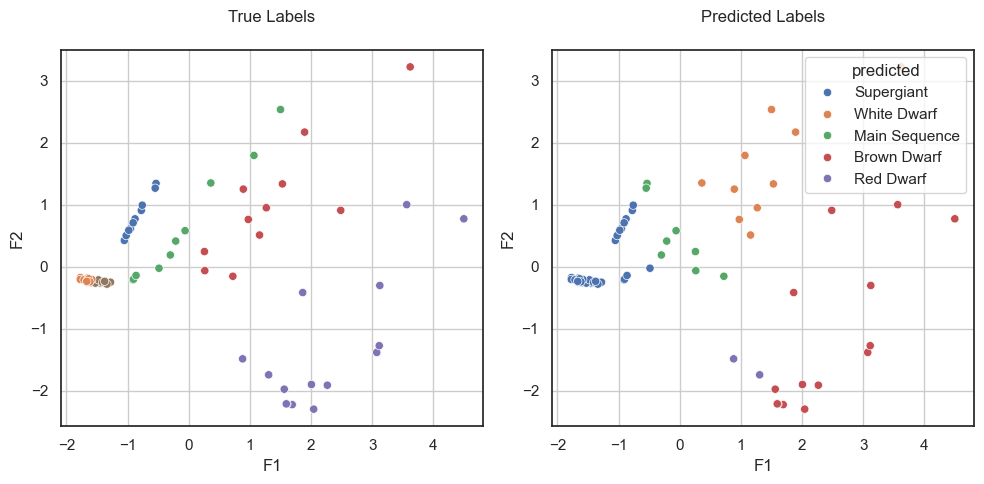

In [184]:
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_test, x='F1', y='F2', hue='true_labels', legend=False)
plt.grid()
plt.title('True Labels')

plt.subplot(1, 2, 2)
plt.grid()
sns.scatterplot(data=df_test, x='F1', y='F2', hue='predicted', legend=True)
plt.title('Predicted Labels')

## ICA

ICA applied to multivariate data looks for a sequence of orthogonal projections such that the projected data look as far from Gaussian as possible. With pre-whitened data, this amounts to looking for components that are as independent as possible.

In [185]:
R = StandardScaler()
X_scaled_r = R.fit_transform(X)
y = df_stars['Star type'].to_numpy()

In [186]:
Fast = FastICA(n_components=2)
Fasted = Fast.fit_transform(X_scaled_r)

In [187]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(Fasted, labels, test_size=0.3, shuffle=True, random_state=42)

In [188]:
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='accuracy', verbose=3, refit=True, return_train_score=True)
grid.fit(X_train_r, y_train_r)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 1/10] END cluster__n_neighbors=2;, score=(train=0.987, test=0.941) total time=   0.0s
[CV 2/10] END cluster__n_neighbors=2;, score=(train=0.987, test=1.000) total time=   0.0s
[CV 3/10] END cluster__n_neighbors=2;, score=(train=0.987, test=1.000) total time=   0.0s
[CV 4/10] END cluster__n_neighbors=2;, score=(train=0.980, test=0.882) total time=   0.0s
[CV 5/10] END cluster__n_neighbors=2;, score=(train=0.987, test=1.000) total time=   0.0s
[CV 6/10] END cluster__n_neighbors=2;, score=(train=0.987, test=0.882) total time=   0.0s
[CV 7/10] END cluster__n_neighbors=2;, score=(train=0.987, test=1.000) total time=   0.0s
[CV 8/10] END cluster__n_neighbors=2;, score=(train=0.987, test=1.000) total time=   0.0s
[CV 9/10] END cluster__n_neighbors=2;, score=(train=0.993, test=0.938) total time=   0.0s
[CV 10/10] END cluster__n_neighbors=2;, score=(train=0.993, test=0.938) total time=   0.0s
[CV 1/10] END cluster__n_neighbors=3;,

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'cluster__n_neighbors': [2, 3, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_neighbors,3


In [189]:
print(f'Score : {accuracy_score(grid.best_estimator_.predict(X_test_r), y_test_r)*100:.3} %')

Score : 98.6 %


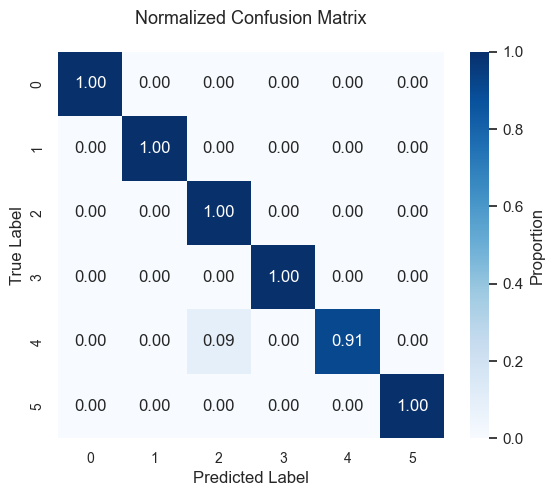

In [190]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, grid.best_estimator_.predict(X_test_r))

# Compute confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

# Create figure
plt.figure(figsize=(6, 5))

sns.set_theme(style='white')
ax = sns.heatmap(
    cm_normalized, 
    annot=True, fmt=".2f", cmap='Blues',
    #xticklabels=labels,
    #yticklabels=labels,
    square=True,
    cbar_kws={'label': 'Proportion'}
)

# Axis labels
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.title("Normalized Confusion Matrix", fontsize=13)
plt.tight_layout()


In [191]:
df_test = pd.DataFrame({
    'F1' : X_test_r[:,0],
    'F2' : X_test_r[:,1],
    'true_labels' : y_test_r,
    'predicted': grid.best_estimator_.predict(X_test_r)
})

Text(0.5, 1.0, 'Predicted Labels')

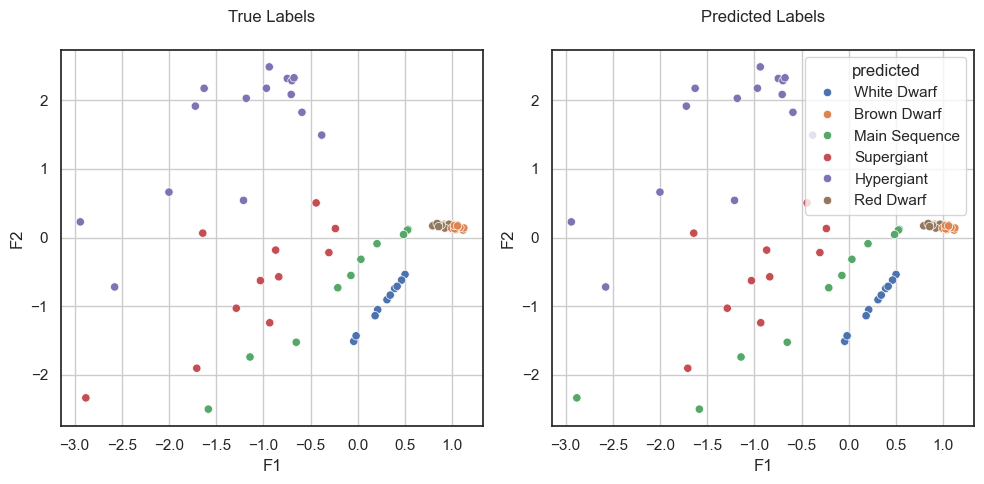

In [192]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_test, x='F1', y='F2', hue='true_labels', legend=False)
plt.grid()
plt.title('True Labels')


plt.subplot(1, 2, 2)
sns.scatterplot(data=df_test, x='F1', y='F2', hue='predicted', legend=True)
plt.grid()
plt.title('Predicted Labels')